In [1]:
import os, math, h5py
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, Tuple
from torch import Tensor
from torch.utils.data import Subset, DataLoader
from tqdm import tqdm
from models import DriftModel, Interpolant
from utils import TrajectoryDataset, to_grid
from types import SimpleNamespace

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
# Config
WINDOW = 7  # must be >=2 (this decides cond channels)
CKPT_PATH = f"./checkpoints/latest_window_{WINDOW}_cosine_normalize.best.pt"   # your trained weights
TRAIN_H5 = "/central/scratch/sotakao/sqg_train_data/3hrly/sqg_pv_train.h5"
VAL_H5 = "/central/scratch/sotakao/sqg_train_data/3hrly/sqg_pv_valid.h5"
USE_VAL = True  # True -> pick from VAL_H5, else TRAIN_H5
INDEX = 0   # which trajectory to demo
BETA_FN = "t^2"  # 't' or 't^2'
SIGMA_COEF = 1.0
EM_STEPS = 500
GUIDE = 0.1 # measurement guidance strength (0 disables)
NORMALIZE = True

# simulate sparse obs (mask target) for demo; replace with your real operator + y_obs if you have one
SIM_SPARSE_OBS = True
OBS_RATIO = 0.1  # 10% pixels observed
OBS_NOISE_STD = 0.0

In [3]:
data_cfg = SimpleNamespace(
    train_path=TRAIN_H5,          # HDF5 file path
    val_path=VAL_H5,          # HDF5 file path
    batch_size=32,
    num_workers=4,
    C=2,
    H=64,
    W=64,
    window=WINDOW,
    normalize=True,
    shuffle=True,
    persistent_workers=True,
    pin_memory=True,
    grid_kwargs={"normalize": False}
)

train_cfg = SimpleNamespace(
    device=device,     # "cuda" or "cpu"
    base_lr=2e-4,
    epochs=10,
    max_grad_norm=1.0,
    print_every=100,
    sample_every_steps=1000,
    save_every_steps=5000,
    ckpt_path="./checkpoints/latest.pt",
    run_name="",
    use_wandb=False,
    wandb_project="sqg_min",
    wandb_entity=None,
    overfit=False
)

model_cfg = SimpleNamespace(
    unet_channels=64,
    unet_dim_mults=(1, 2, 2),
    unet_resnet_block_groups=8,
    unet_learned_sinusoidal_dim=32,
    unet_attn_dim_head=64,
    unet_attn_heads=4,
    unet_learned_sinusoidal_cond=True,
    unet_random_fourier_features=False,
    use_classes=False,
)

interp_cfg = SimpleNamespace(
    sigma_coef=1.0,
    beta_fn="t^2",
    t_min_train=0.0,
    t_max_train=1.0,
    t_min_sampling=0.0,
    t_max_sampling=0.999,
    EM_sample_steps=500
)

In [4]:
trainset = TrajectoryDataset(
    file=TRAIN_H5,
    window=WINDOW,
    flatten=False,
    normalize=True,
)

In [5]:
idx = torch.arange(0, 1000)            # 64 samples is plenty
tiny_train = Subset(trainset, idx)
tiny_dl = DataLoader(
    tiny_train, batch_size=data_cfg.batch_size,
    shuffle=True, num_workers=0, pin_memory=False
)

In [6]:
model = DriftModel(data_cfg, model_cfg, cond_channels=(data_cfg.window-1)*data_cfg.C).to(train_cfg.device)
interp = Interpolant(interp_cfg)
opt = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

U = torch.distributions.Uniform(low=interp_cfg.t_min_train, high=interp_cfg.t_max_train)

def prep(batch):
    x = batch.to(train_cfg.device)                  # (B,T,C,H,W)
    B,T,C,H,W = x.shape
    cond = x[:, :-1].reshape(B, (T-1)*C, H, W)      # (B,(T-1)C,H,W)
    z0   = x[:, -2]                                 # (B,C,H,W)
    z1   = x[:, -1]
    D = {"z0": z0, "z1": z1, "cond": cond, "N": B}
    D["t"] = U.sample((B,)).to(train_cfg.device)
    D["noise"] = torch.randn_like(z0)               # (B,C,H,W)  <- channel-matched
    D = interp.interpolant_coefs(D)
    D["zt"] = interp.compute_zt_new(D)              # must use ALL channels of z0!
    D["drift_target"] = interp.compute_target_new(D)
    return D

def img_sq_norm(x): return x.pow(2).sum((-1,-2,-3))

model.train()
step, max_steps = 0, 400
for epoch in range(200):                  # few passes
    for batch in tiny_dl:
        if step >= max_steps: break
        D = prep(batch)
        out = model(D["zt"], D["t"], cond=D["cond"])
        loss = img_sq_norm(out - D["drift_target"]).mean()
        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        if step % 20 == 0:
            print(f"[step {step}] loss={loss.item():.6f}")
        step += 1
    if step >= max_steps: break


NOT USING CLASSES IN UNET
[step 0] loss=10592.441406
[step 20] loss=7930.319824
[step 40] loss=5902.577148
[step 60] loss=5040.349609
[step 80] loss=5168.029785
[step 100] loss=3791.749268
[step 120] loss=4050.347168
[step 140] loss=3998.799805
[step 160] loss=2895.086426
[step 180] loss=3266.548340
[step 200] loss=5359.428223
[step 220] loss=2639.699707
[step 240] loss=3001.089844
[step 260] loss=2713.080566
[step 280] loss=2310.634277
[step 300] loss=2382.575684
[step 320] loss=2892.169434
[step 340] loss=2615.419922
[step 360] loss=2154.577148
[step 380] loss=2592.689697


In [10]:
import math, torch
@torch.no_grad()
def em_sample_uncond(model, interp, base, cond, steps=200):
    device = base.device
    ts = torch.linspace(0.0, 0.999, steps, device=device)
    dt = float(ts[1] - ts[0])
    xt = base.clone()
    for t in ts:
        tb = t.repeat(xt.shape[0])
        bF  = model(xt, tb, cond=cond)
        sig = interp.sigma(tb)
        mu  = xt + bF * dt
        xt  = mu + sig * torch.randn_like(mu) * math.sqrt(dt)  # try removing noise below
    return xt

# Take one batch from tiny_dl
batch = next(iter(tiny_dl))
D = prep(batch)
pred = em_sample_uncond(model, interp, base=D["z0"], cond=D["cond"], steps=200)

# quick MSE against z1 (lower is better)
mse = ((pred - D["z1"])**2).mean().item()
mse_persist = ((D["z0"] - D["z1"])**2).mean().item()  # persistence baseline
print("MSE(pred, z1) =", mse, " | baseline MSE(z0, z1) =", mse_persist)


MSE(pred, z1) = 0.13142843544483185  | baseline MSE(z0, z1) = 0.23830145597457886


Text(0.5, 1.0, 'Pred z1')

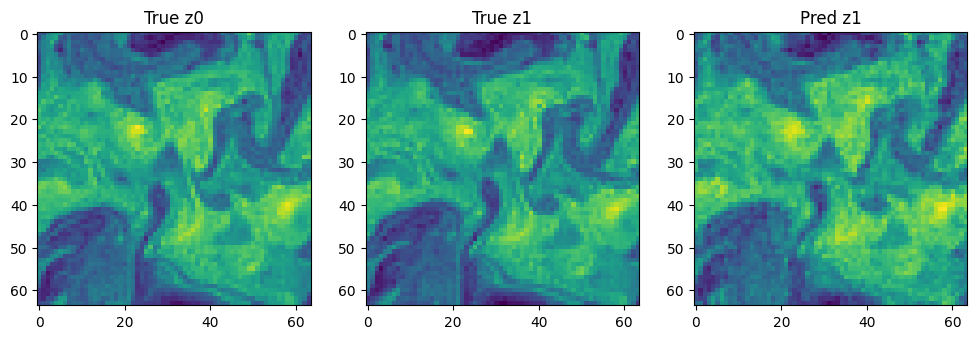

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(D["z0"][0,0].cpu().numpy())
axs[0].set_title("True z0")
axs[1].imshow(D["z1"][0,0].cpu().numpy())
axs[1].set_title("True z1")
axs[2].imshow(pred[0,0].cpu().numpy())
axs[2].set_title("Pred z1")